In [1]:
# Prelude

# Just a little Jupyter hacking to allow code snippets to proceed without exceptions

from IPython.core.magic import register_cell_magic

@register_cell_magic('code_for_illustration')
def code_for_illustration(line, cell):
    try:
        exec(cell)
    except Exception as e:
        print("Code snippet for illustration only")
        
@register_cell_magic('do_not_run_in_jupyter')
def do_not_run_in_jupyter(line, cell):
    return

# XSEDE Webinar: Python and Performance

<b>Chris Myers &nbsp;&nbsp; ( c.myers @ cornell.edu )<br />
    <br />
Center for Advanced Computing (CAC)&nbsp;&nbsp;  & &nbsp;&nbsp; Department of Physics<br />
    <br />
Cornell University<br />
</b>

<hr />

These slides are available as a Jupyter notebook in a github repository at https://github.com/CornellCAC/CVW_PyHP (in the notebook file named PyPerfWebinar2.ipynb).

This webinar is intended as an overview and complement to the Cornell Virtual Workshop (CVW) tutorial on "Python for High Performance", at https://cvw.cac.cornell.edu/python .  

<table style="float:left"><tr>
    <td><img src="images/cornell_seal_simple_b31b1b.png" width="200"/></td>
    <td>                      </td>
    <td><img src="images/XSEDE_Logo_Blue.png" width="400"/></td>
    </tr></table>

# Code of Conduct

XSEDE has an external code of conduct which represents our commitment to providing an inclusive and harassment-free environment in all interactions regardless of race, age, ethnicity, national origin, language, gender, gender identity, sexual orientation, disability, physical appearance, political views, military service, health status, or religion. The code of conduct extends to all XSEDE-sponsored events, services, and interactions.

Code of Conduct: https://www.xsede.org/codeofconduct 

Contact:
* Event organizer: Susan Mehringer, CAC (shm7@cornell.edu) 
* XSEDE ombudspersons:
    * Linda Akli, Southeastern Universities Research Association (akli@sura.org)
    * Lizanne Destefano, Georgia Tech (lizanne.destefano@ceismc.gatech.edu)
    * Ken Hackworth, Pittsburgh Supercomputing Center (hackworth@psc.edu)
    * Bryan Snead, Texas Advanced Computing Center (jbsnead@tacc.utexas.edu)
* Anonymous reporting form available at https://www.xsede.org/codeofconduct




# Introduction

* Python is interpreted (i.e., executed in an interpreter)
* Compiled programs (e.g., C/C++, Fortran) generally run faster than interpreted programs
* Interpreted languages are often better for rapid prototyping and high-level program control
* Optimizing "time to science" might suggest prioritizing program development time over computational run time (or maybe vice versa)
* <b>How should we best use Python for applications that require numerically intensive computations?</b>
* <b>Can we have the best of both worlds (expressiveness and performance)?</b>
* <b>If there are tradeoffs, where are they and how can they be mitigated?</b>
* As with most things in Python, there is no one answer, and the landscape is constantly changing...

# CPython 

* CPython: the reference implementation of the language, and the most widely used interpreter
    * generally installed as "python"
* Alternative implementations/interpreters exist (e.g., IronPython, Jython, PyPy) &mdash; we will not consider these here
* IPython & Jupyter kernel are thin layers on top of CPython to provide additional functionality 
    * but typically use <code>python myprogram.py</code> for long-running programs in batch
* CPython compiles Python source code to bytecodes, and then operates on those

# Python/C API and extension modules

* CPython, written in C, is accompanied by an Application Programming Interface (API) that enables communication between Python and C (and thus to basically any other language)
* Python/C API allows for compiled chunks of code to be called from Python or executed within the CPython interpreter &rarr; <b>extension modules</b>
* Compiled shared object library (.so, .dll, etc.) is accessed through Python/C API
    * compiled code executes operations of interest
    * wrapper/interface code consists of calls to Python/C API and underlying compiled code
* Can be imported into python interpreter just as pure Python source code can
* Much core functionality of the Python language and standard library are written in C

# Hybrid Codes

It is often advantageous to blend high-level languages for control with low-level languages for performance.  Overall performance depends on the granularity of computations in compiled code and the overhead required to communicate between languages.

![Hybrid Codes](images/PyCompiled4.png)

There are many different tools that support the interleaving of Python and compiled extension modules.

# Outline

* Introduction
* Three main strategies for improved performance
    * More compiled code
    * Parallel processing
    * Faster native Python
* Performance assessment
* Supplementary material

<center><img src="images/PyAxes.png" /></center>

# More compiled code

* Compiled third-party libraries
* Compiling custom code


<center><img src="images/PyMoreCompiled.png" /></center>

# Third-Party Libraries for Numerical & Scientific Computing
#### a.k.a. The Python Scientific Computing Ecosystem

* Most specific functionality for scientific computing is provided by third-party libraries, which are typically a mix of Python code and compiled extension modules
    * <b>NumPy</b>: multi-dimensional arrays, linear algebra, random numbers
    * <b>SciPy</b>: routines for integration, optimization, root-finding, interpolation, etc.
    * <b>Pandas</b>: Series and Dataframes for tabular data and statistics (e.g., from spreadsheets)
    * <b>Scikit-learn, TensorFlow, Caffe, PyTorch, Keras</b>: machine learning
    * <b>Matplotlib, Seaborn, Bokeh</b>: plotting
    * <b>NetworkX</b>: networks
    * etc.
* Bundled distributions (e.g., Anaconda) contain many of these, with tools for installing additional packages

# NumPy

* NumPy = "Numerical Python", the cornerstone of the scientific computing ecosystem for Python
* largely written in C, with links to BLAS and LAPACK libraries for linear algebra
* provides multidimensional arrays and array-level operations (a form of vectorization)



* <b>conventional wisdom</b>: avoid loops in Python and use array syntax
* <b>a challenge</b>: figuring out how to express complex operations solely using array syntax
    * including indexing, slicing, and broadcasting
* <b>a caveat</b>: convenient syntax can disguise performance inefficiencies (e.g., temporary arrays)

# Array operations

#### Aggregated operations over arrays

In [2]:
import numpy as np
a = np.random.random((1000,1000))
b = np.random.random((1000,1000))

log_a = np.log(a)  # an example of a "universal function" (ufunc) -- operates on scalars and arrays

c = a + b    # throws ValueError if a and b not the same shape

<center><img src="images/PyCompiled2b.png" /></center>

#### The challenge of more complex operations

In [3]:
# numpy multiplicative outer product

def outer(a,b):
    multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)

#### The caveat of array temporaries

In [4]:
# The problem of temporary array creation

d = a + 2*b + 3*c

# temporaries: 3*c, 2*b, (2*b)+(3*c), a + ((2*b) + (3*c))

# NumPy and optimized libraries

* NumPy performance can be enhanced if linked to optimized libraries
    * ```numpy.__config__.show()``` to list what BLAS, LAPACK libraries numpy is linked to
* Intel MKL (Math Kernel Library) for Intel processors &mdash; bundled with Anaconda Python distribution
* also, OpenBLAS and ATLAS
* On multi-core architectures, NumPy linear algebra operations using BLAS & LAPACK can leverage thread-based parallelism for free by setting environment variables appropriate for processor
    * ```MKL_NUM_THREADS = N```        # if using MKL
    * ```OMP_NUM_THREADS = N```        # if libraries support OpenMP

# SciPy

* SciPy = "Scientific Python"
* sits on top of NumPy, wrapping many C and Fortran numerical routines, with convenient Python interface
* routines for integration, optimization, root-finding, interpolation, fitting, etc.
* Python callbacks enable ease-of-use, but with some performance penalty

<center><img src="images/PyCallable2b.png" /></center>

# Compiling Custom Code

* Compilation frameworks
    * Numba and Cython
    * internal code generation for deep learning neural networks: Tensorflow, PyTorch, etc.
* Wrapper and interface generators


# Numba

* a just-in-time (JIT) compiler that compiles a subset of Python and NumPy source to machine code for execution in CPython
* uses LLVM to convert Python bytecodes to intermediate representation (IR), and generates optimized C code from that
* can be configured in more detail, but some performance improvements simply via addition of @jit decorator
* multicore parallelism easily supported through options to decorators
* Nice tutorial at SciPy 2017 by Gil Forsyth & Lorena Barba ( https://www.youtube.com/watch?v=1AwG0T4gaO0 )

# Upending the conventional wisdom via compilation

In [5]:
import numpy as np
from numba import jit

X, Y, Z = np.random.random((3,1000,1000))

def f1(x,y,z):
    return x + 2*y + 3*z

def f2(x,y,z):
    result = np.empty_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            result[i,j] = x[i,j] + 2*y[i,j] + 3*z[i,j]
    return result

@jit
def f3(x,y,z):
    result = np.empty_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            result[i,j] = x[i,j] + 2*y[i,j] + 3*z[i,j]
    return result

@jit
def f4(x,y,z):
    return x + 2*y + 3*z

r1 = f1(X,Y,Z); r2 = f2(X,Y,Z); r3 = f3(X,Y,Z); r4 = f4(X,Y,Z)

In [6]:
%timeit f1(X,Y,Z)
%timeit f2(X,Y,Z)
%timeit f3(X,Y,Z)
%timeit f4(X,Y,Z)

3.68 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.19 s ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.92 ms ± 70.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.74 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Cython

* a C-like superset of the Python language that adds capabilities for type declarations
* a system for converting chunks of Python/Cython code into C for compilation and execution within CPython


* can be used to compile extension modules ahead of time, or for on-the-fly compilation using IPython magic functions (%%cython)
* mature technology used by many packages in Python ecosystem to optimize particular functionality (NumPy, Pandas, Scikit-learn, etc.)
* provides support for OpenMP-based parallelism through the cython.parallel module
* Nice tutorial at SciPy 2015 by Kurt Smith ( https://www.youtube.com/watch?v=gMvkiQ-gOW8 )

## Wrapper and Interface Generators

Useful if you have an existing code base (C/C++, Fortran, etc.) that you would like to be able to call from Python

Typically a multi-step process:
* Function and class declarations &rarr; Python/C API code generation (wrapper code)
* Wrapper code compiled and linked with underlying library &rarr; <b>.so file</b>
* Possibly some additional Python code generated

## Wrapper and Interface Generators


Some of the many packages available:
* <b>CFFI</b> and <b>ctypes</b> provide \"foreign function interfaces\", or lightweight APIs, for calling C libraries from within Python
* <b>Boost.python</b> helps write C++ libraries that Python can import
* <b>SWIG</b> reads C and C++ header files and generates a library than Python (or many other scripting languages) can import
* <b>F2PY</b> reads Fortran code and generates a library that Python can import
* <b>PyCUDA</b> and PyOpenCL provide access within Python to GPUs

# Parallel Processing

* Parallelization: across threads, across cores, across processors
    * ...to reduce wallclock time to solution
    * ...to solve bigger problems that don't fit in a single processor
* CPython uses a Global Interpreter Lock (GIL): only one thread can run at a time
* GIL does not apply to multithreaded code in compiled library (e.g., MKL) or non-blocking I/O
* Multiple Python processes can run concurrently (each with their own GIL)
* (and new development is taking place to enable multiple interpreters within a single process)

<center><img src="images/PyParallel.png" /></center>


# Multiprocessing and concurrent.futures modules

* control of multiple processes and communication between them
* useful for multiprocessing within a multi-core, shared memory processor

In [7]:
%%do_not_run_in_jupyter  # Jupyter and multiprocessing do not work well together

from multiprocessing import Pool

def f(x):
    return x*x

with Pool(4) as p:
    print(p.map(f, range(100))

# Message passing with mpi4py

* MPI = "Message Passing Interface" &mdash; a widely-used standard for parallel processing 
* Many Python wrappers to MPI developed over the years; mpi4py is probably most widely used at this time
* use ```mpiexec``` or ```ibrun``` in shell to run a python program over multiple processors
    * e.g., ```ibrun python myprogram.py``` on Stampede2 at TACC

## mpi4py

In [8]:
# Typical MPI fare: communicators, ranks, sends, receives, etc.

from mpi4py import MPI
comm = MPI.COMM_WORLD
print('rank', comm.Get_rank())
print('size', comm.Get_size())

import numpy as np
data = np.arange(10, dtype=np.float64)
data2 = np.zeros(10, dtype=np.float64)
print('data2 =', data2)

comm.Isend(data, dest=0, tag=20)
comm.Recv(data2, source=0, tag=20)
print('data2 =', data2)

rank 0
size 1
data2 = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
data2 = [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


# Exercise: Estimating $\pi$ via Monte Carlo using mpi4py

[Exercise in CVW on "Python for High Performance"](https://cvw.cac.cornell.edu/python/exercise)

<center><img src="images/throwingdarts.png" width="600"></center>

## Some Other Parallel Tools

* <b>Dask</b>
    * distributed NumPy arrays and Pandas DataFrames
    * task scheduling interface for custom workflows
* <b>Joblib</b>
    * lightweight pipelining with support for parallel processing
    * specific optimizations for NumPy arrays
* <b>ipyparallel</b>
    * parallel and distributed computing within IPython
* <b>pymp</b>
    * "brings OpenMP-like functionality to Python"
* <b>asyncio</b>
    * "library to write concurrent code using the async/await syntax"
    * well-suited for IO-bound and networking code

# Faster Native Python


<center><img src="images/PyFaster.png" /></center>

* Collections and containers: the right data structure for the job
* Lazy evaluation
* Memory management


* More details in the supplementary material below and at <a href="https://cvw.cac.cornell.edu/python/faster">https://cvw.cac.cornell.edu/python/faster</a>


## Collections and containers

Use the right data structure for the job

For example, numerical performance of membership testing for sets and lists containing the same data can be very different:
    * sets ~ O(1)
    * lists ~ O(N)

In [9]:
set1  = set(range(0,10000))
list1 = list(range(0,10000))

%timeit 9800 in set1

%timeit 9800 in list1

42.1 ns ± 0.912 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
104 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Performance Assessment

* Algorithms and computational architectures are complex: be empirical about performance
* Timing: getting timing information for particular operations
* Profiling: figuring out where time is being spent

IPython magic functions

* %timeit : uses timeit module from Python Standard Library
* %prun : uses profile module from Python Standard Library
* %lprun : uses line_profiler module (separate install)

In [10]:
from scipy.integrate import solve_ivp
import numpy as np

sigma = 10
rho = 28
beta = 8.0/3

def lorenz(t, xyz):
    x,y,z = xyz
    xdot = sigma*(y-x)
    ydot = x*(rho-z) - y
    zdot = x*y - beta*z
    return [xdot, ydot, zdot]

def integrate_lorenz(ic=[1.,1.,1.], t_span=(0.,100.)):
    sol = solve_ivp(lorenz, t_span, ic, t_eval=np.linspace(*t_span, 10000))
    return sol

In [11]:
%prun integrate_lorenz()

In [12]:
# first need to install line_profiler package; typically not installed by default

%load_ext line_profiler

%lprun -f lorenz -f integrate_lorenz integrate_lorenz()



# Optimizing Time to Science

In [13]:
sol = integrate_lorenz()
xs, ys, zs = sol['y']

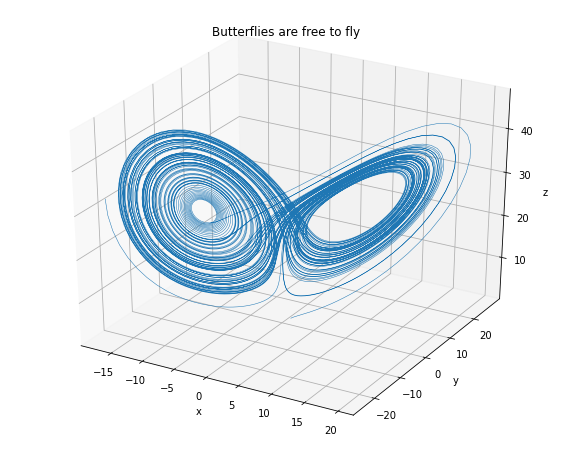

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib inline
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("x");
ax.set_ylabel("y");
ax.set_zlabel("z");
ax.set_title('Butterflies are free to fly');

## Summary

* Python and Performance together in one big tent
* There is no one answer: think about what works best for what you need to accomplish
* Make sure you have the right algorithms, do not prematurely optimize, and be empirical about performance

For more detail, see the Cornell Virtual Workshop (CVW) tutorial on "Python for High Performance", at https://cvw.cac.cornell.edu/python .

These slides are available as a Jupyter notebook named PyPerfWebinar2.ipynb at: https://github.com/CornellCAC/CVW_PyHP 

There is supplementary material at the end of this notebook going into some of these issues in more detail.


# Supplementary material

* Jupyter and RISE
* Extension modules in more detail
* NumPy: outer products and broadcasting
* Python callbacks in SciPy
* Parallel execution with numba
* Cython
    * Pure Python vs. Cython
    * Cython timing comparison
* Multiprocessing
    * concurrent.futures
    * example from networkx
* Writing faster Python
    * Collections and containers
    * Lazy evaluation

# Questions?

* Extension modules and hybrid codes
* Three main strategies
    * More compiled code
        * Compiled libraries
        * Compilation frameworks
        * Wrapper and interface generators
    * Parallel processing
        * multiprocessing
        * MPI
    * Faster native Python
* Performance assessment
* Anything else regarding Python and Performance?

# Jupyter and RISE

This material is contained in a live Jupyter notebook.  The RISE extension enables us to format the notebook as a series of slides.  It is useful to define a few new "cell magics" for Jupyter so that this can be run smoothly.

* Jupyter: https://jupyter.org
* RISE: https://rise.readthedocs.io/en/stable/

In [15]:
# Just a little Jupyter hacking to allow code snippets to proceed without exceptions

from IPython.core.magic import register_cell_magic

@register_cell_magic('code_for_illustration')
def code_for_illustration(line, cell):
    try:
        exec(cell)
    except Exception as e:
        print("Code snippet for illustration only")
        
@register_cell_magic('do_not_run_in_jupyter')
def do_not_run_in_jupyter(line, cell):
    return

# Extension module example: the math library

In [16]:
# Linux & MacOS only -- examine the mix of API and math functions in the math .so shared library

import math
print(math.cos(math.pi))

print(math.__file__)

!nm $math.__file__

-1.0
/Users/myers/opt/anaconda3/envs/PyPerf/lib/python3.8/lib-dynload/math.cpython-38-darwin.so
                 U _PyArg_ParseTuple
                 U _PyBool_FromLong
                 U _PyErr_Clear
                 U _PyErr_ExceptionMatches
                 U _PyErr_Format
                 U _PyErr_NoMemory
                 U _PyErr_Occurred
                 U _PyErr_SetFromErrno
                 U _PyErr_SetString
                 U _PyExc_MemoryError
                 U _PyExc_OverflowError
                 U _PyExc_TypeError
                 U _PyExc_ValueError
                 U _PyFloat_AsDouble
                 U _PyFloat_FromDouble
                 U _PyFloat_Type
0000000000001040 T _PyInit_math
                 U _PyIter_Next
                 U _PyLong_AsDouble
                 U _PyLong_AsLongAndOverflow
                 U _PyLong_AsLongLongAndOverflow
                 U _PyLong_AsUnsignedLongLong
                 U _PyLong_FromDouble
                 U _PyLong_FromLong
    

# NumPy: outer products and broadcasting

In [17]:
# numpy multiplicative outer product

def outer(a,b):
    multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)

# e.g., generalized outer product to compute pairwise Hamming distances between all subsequences in a 2D array

def Hamming_outer(a0,a1):
    return np.sum(np.bitwise_xor(a0[:,np.newaxis], a1[np.newaxis,:]), axis=2)

# Python callbacks in SciPy

![Python callbacks](images/PyCallable.png)

* can hack things with the help of wrapper generation tools to get compiled routines to accept a pointer to a compiled callback function (func in this example)
* scipy.LowLevelCallable recently introduced to work with some functions (not solve_ivp)

# Parallel execution with Numba

In [18]:
from numba import prange

@jit(nopython=True, parallel=True)
def f5(x,y,z):
    result = np.empty_like(x)
    for i in prange(x.shape[0]):
        for j in prange(x.shape[1]):
            result[i,j] = x[i,j] + 2*y[i,j] + 3*z[i,j]
    return result

@jit(nopython=True, parallel=True)
def f6(x,y,z):
    return x + 2*y + 3*z


r5 = f5(X,Y,Z); r6 = f6(X,Y,Z);

In [19]:
%timeit f5(X,Y,Z)
%timeit f6(X,Y,Z)

983 µs ± 69.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.27 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Comparing pure Python vs. Cython

In [20]:
# Example: adapted from Cython tutorial at https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html#primes
# pure Python code

def primes(nb_primes):
    if nb_primes > 1000:
        nb_primes = 1000

    p = [0]*nb_primes
    len_p = 0  # The current number of elements in p.
    n = 2
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1

    # Let's return the result in a python list:
    #result_as_list  = [prime for prime in p[:len_p]]
    #return result_as_list
    return p

primes100 = primes(100)
print(primes100)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541]


In [21]:
%load_ext Cython

In [22]:
%%cython -a

# Cython code: note type declarations and cdef statements
# Cython alterations to source code are visible in the output window below

def primes_cython(int nb_primes):
    cdef int n, i, len_p
    cdef int p[1000]
    if nb_primes > 1000:
        nb_primes = 1000

    len_p = 0  # The current number of elements in p.
    n = 2
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1

    # Let's return the result in a python list:
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

cprimes100 = primes_cython(100)
print(cprimes100)

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541]


# Cython timing comparison

In [23]:
%timeit primes(100)

%timeit primes_cython(100)

392 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
18 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Multiprocessing with concurrent.futures

In [24]:
%%do_not_run_in_jupyter

# or, equivalently

import concurrent.futures

executor = concurrent.futures.ProcessPoolExecutor(max_workers=4)
print(list(executor.map(f, range(100))))

# More multiprocessing (from networkx docs)

[Link to networkx page](https://networkx.github.io/documentation/stable/auto_examples/advanced/plot_parallel_betweenness.html#sphx-glr-download-auto-examples-advanced-plot-parallel-betweenness-py)

In [25]:
%%code_for_illustration

# just a subset of the code (download full example at link above to run)

def _betmap(G_normalized_weight_sources_tuple):
    return nx.betweenness_centrality_source(*G_normalized_weight_sources_tuple)

def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.map(_betmap,
                  zip([G] * num_chunks,
                      [True] * num_chunks,
                      [None] * num_chunks,
                      node_chunks))

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

# Collections and containers

Use the right data structure for the job

As with membership testing, computing set intersections is much faster using sets than lists

In [26]:
# item lookup is much faster for sets and dictionaries than for lists (for which lookup is O(N))

set1 = set(range(0,1000))        # create a set with a bunch of numbers in it
set2 = set(range(500,2000))     # create another set with a bunch of numbers in it
isec = set1 & set2                # same as isec = set1.intersection(set2)

list1 = list(range(0,1000))      # create a list with a bunch of numbers in it
list2 = list(range(500,2000))   # create another list with a bunch of numbers in it
isec = [e1 for e1 in list1 for e2 in list2 if e1==e2]    # uses list comprehensions

%timeit set1 & set2
%timeit [e1 for e1 in list1 for e2 in list2 if e1==e2]

14.5 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
38.3 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Lazy evaluation

* a strategy implemented in some programming languages whereby certain objects are not produced until they are needed
* often used in conjunction with functions that produce collections of objects
* if you only need to iterate over the items in a collection, you don't need to produce that entire collection

Python provides a variety of mechanisms to support lazy evaluation:

* generators: like functions, but maintain internal state and ```yield``` next value when called
* dictionary views (keys and values)
* range:   ```for i in range(N)```
* zip:    ```pairs = zip(seq1, seq2)```
* enumerate:    ```for i, val in enumerate(seq)```
* open:    ```with open(filename, 'r') as f```